# June 28 data electrode A RIVER sample NDA set

1.29E-07 M CuT (measured by ICP), pH 6.56 (ambient)

electrode A is the original electrode (old one)


In [367]:
% setup environment
% set path to equilibrium solver
txt=pwd;
n=length(txt);
rootpath=txt; %txt(1:n-8);
PHREEQCpath=[rootpath,'/runPHREEQC'];
addpath(PHREEQCpath);
JEQUILIBpath=[rootpath,'/JEQUILIB']; addpath(JEQUILIBpath);
Cumodelspath=[rootpath,'/Cutableaus']; addpath(Cumodelspath);
% clear data and number format
clear; format short e
% turn off warnings
warning off
graphics_toolkit ("notebook"); 
graphics_toolkit ("plotly"); 

In [368]:
% put in constants
VT=0.05; %total volume
stockCuconc=0.0152067;

In [369]:
% put in data

originalsamplemVnpH=[...
%pH mV
6.611	20.6
];

calibdata=[...
%volCu mV pH
0  85.4 1.76
50  116.1 1.757
150 129.9 1.758 
400 147.1 1.76 
900 164.1 1.754 
%1650 171.8 1.758 
%2650 175.3 1.764 
];




pH = 6.6110e+00


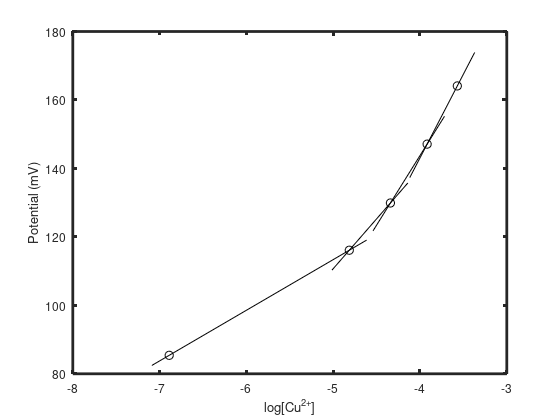

In [370]:
graphics_toolkit("notebook")
% pull out the sample data
pH=mean(originalsamplemVnpH(:,1))
mVoriginal=(originalsamplemVnpH(:,2));

%pull out the calibration data
addedCuvol=calibdata(:,1)'*1e-6; pHcalib=calibdata(:,3); mV=calibdata(:,2)'; CuTmeas=1.29E-07; CuT=CuTmeas;
CuTplus=(CuTmeas*(VT)+addedCuvol*stockCuconc)./(VT+addedCuvol);

plot(log10(CuTplus),mV,'ko'); hold on

%chlorocorrecxtion
%BF1=2.49; BF2=1.14; BF3=0.9; ClT=4.9904e-4; %from Inorg. Chem. 1983. 22. 3323-3326.
%CuTplus=CuTplus./(1+BF1*ClT+BF2*ClT^2+BF3*ClT^3);

%determine all the slopes and intercepts for each pair of mV values
for i=1:length(mV)-1
    param=polyfit([log10(CuTplus(i)) log10(CuTplus(i+1))],[mV(i) mV(i+1)],1);
    val=polyval(param,[log10(CuTplus(i))-0.2 log10(CuTplus(i+1))+0.2]);
    plot([log10(CuTplus(i))-0.2 log10(CuTplus(i+1))+0.2],val,'k-')
    m(i)=param(1); Eo(i)=param(2); 
    %two ways to define what logCu is for the Eo and m values. need to pick the approach that consistently works best
    %logCuT(i)=mean([log10(CuTplus(i)) log10(CuTplus(i+1))]); % calib Cu is the midpoint
    logCuT(i)=[log10(CuTplus(i))]; % calib Cu is the starting point 
end
xlabel('log[Cu^{2+}]');  ylabel('mV');
set(gca,'fontsize',12); set(gca,'linewidth',2);
xlabel('log[Cu^{2+}]'); ylabel('Potential (mV)')

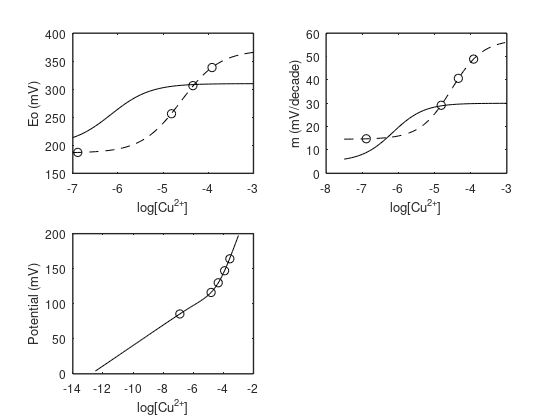

In [371]:
%plot and fit the s and Eo curves to a logit function.

subplot(221); plot(logCuT,Eo,'ko'); subplot(222); plot(logCuT,m,'ko');

%use logisticmodel
%define function
logisticfunction = @(p,logx) (p(1)+(p(2)-p(1))./(1+10.^(p(3)-logx)*p(4)));
errfunction=@(p,logx,meas) (log10(sum((meas-logisticfunction(p,logx)).^2)));

%fit Eo to meta calibration
ptst=[200 310 -6 0.7];
logx=-7:0.1:-3; model=logisticfunction(ptst,logx);
err=errfunction(ptst,logCuT,Eo);
subplot(221); hold on
plot(logx,model,'k-')
% now best fit
options = optimset('Display','off','TolFun',1e-4,'TolX',1e-4);
pbestEo=fminsearch(@(p) errfunction(p,logCuT,Eo),ptst,options);
model=logisticfunction(pbestEo,logx);
plot(logx,model,'k--')

%fit m to meta calibration
ptst=[5 30 -6 0.7];
logx=-7.5:0.1:-3; model=logisticfunction(ptst,logx);
err=errfunction(ptst,logCuT,m);
subplot(222); hold on
plot(logx,model,'k-')
% now best fit
options = optimset('Display','off','TolFun',1e-4,'TolX',1e-4);
pbestm=fminsearch(@(p) errfunction(p,logCuT,m),ptst,options);
model=logisticfunction(pbestm,logx);
plot(logx,model,'k--')

%plot the original data and the metacalibration fit
subplot(223)
plot(log10(CuTplus),mV,'ko'); hold on
logCuTplot=-12.5:0.1:-3; 
for i=1:length(logCuTplot)
    Eocalc=logisticfunction(pbestEo,logCuTplot(i));
    mcalc=logisticfunction(pbestm,logCuTplot(i));
    mVcalc(i)=Eocalc+mcalc*logCuTplot(i);
end
plot(logCuTplot,mVcalc,'k-')

subplot(221); set(gca,'fontsize',12); set(gca,'linewidth',1);
xlabel('log[Cu^{2+}]'); ylabel('Eo (mV)')
    
subplot(222); set(gca,'fontsize',12); set(gca,'linewidth',1);
xlabel('log[Cu^{2+}]'); ylabel('m (mV/decade)')

subplot(223); set(gca,'fontsize',12); set(gca,'linewidth',1);
xlabel('log[Cu^{2+}]'); ylabel('Potential (mV)')


In [372]:
% then use this metacalibration to determine original sample logCu2+

Eooriginal=logisticfunction(pbestEo,log10(CuT))
moriginal=logisticfunction(pbestm,log10(CuT))

logCuoriginal=(mVoriginal-Eooriginal)/moriginal

Eooriginal = 1.8724e+02


moriginal = 1.4777e+01


logCuoriginal = -1.1277e+01


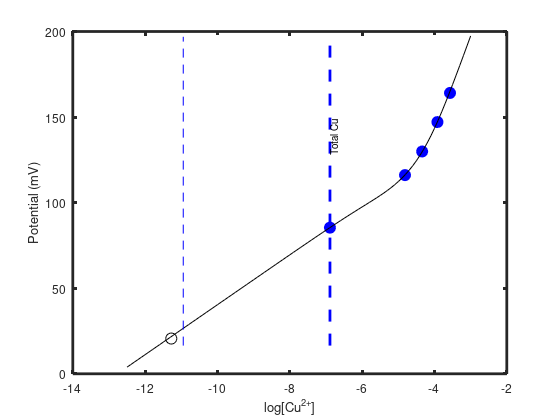

In [373]:
% MODEL FOR COMPARISON
graphics_toolkit("notebook")
%model with just inorganic speciation
%geochemical model
% input the constants and solution chemistry

flag1=2; %flag1 for concentration based search vector (1) or for log based search vector (2).
flag2=1; %flag2 for numerical derivatives (2) or analtyical derivatives (1)
database=[]; 
flag3=0; % flag3 1 for show warnings. 0 no warnings
flag4=0; %if=1 solve tableau one line at a time to get a good initial guess (no solids). really challenging probs only
flag5=0; %if=1 use stored initial guess for including solids

CuT=CuTmeas; inorganicTOTALS=[CuT];
inorganicTOTALS(inorganicTOTALS==0)=1e-16; % get rid of zero values, b/c div by zero error
TOTALS=[inorganicTOTALS]; %TOTALS=inorganicTOTALS;
pH=pH; pe=20.75-pH; PCO2=10^-3.5;
[Cuall,CuOH,CuOH2s,CuOs,CuCO3s,tenorite,malachite,MASSERR]=CuOHCO2opentableauallsolids(pH,pe,PCO2,TOTALS',flag1,flag2,flag3,flag4,flag5,database);
[CuwithCuOs,CuOH,CuOH2s,CuOs,CuCO3s,tenorite,malachite,MASSERR]=CuOHCO2opentableauCuOs(pH,pe,PCO2,TOTALS',flag1,flag2,flag3,flag4,flag5,database);
[Cunosolid,CuOH,CuOH2s,CuOs,CuCO3s,tenorite,malachite,MASSERR]=CuOHCO2opentableaunosolid(pH,pe,PCO2,TOTALS',flag1,flag2,flag3,flag4,flag5,database);

plot(log10(CuTplus),mV,'bo','markersize',8,'markerfacecolor','b'); hold on
plot(logCuTplot,mVcalc,'k-')
plot(logCuoriginal,mVoriginal,'ko','markersize',8)

%plot([log10(Cuall) log10(Cuall)],[min(mVoriginal)-0.2*min(mVoriginal) max(mV)+0.2*max(mV)],'b--')
plot([-10.946 -10.946],[min(mVoriginal)-0.2*min(mVoriginal) max(mV)+0.2*max(mV)],'b--'); hold on
plot([log10(CuT) log10(CuT)],[min(mVoriginal)-0.2*min(mVoriginal) max(mV)+0.2*max(mV)],'b--','linewidth',2)
%plot([-9.576 -9.576],[-100 100],'b--')

text(log10(-11)+0.1,max(mV)-(max(mV)-mean(mVoriginal))/4,'model Cu^{2+}','rotation',90)
text(log10(CuT)+0.1,max(mV)-(max(mV)-mean(mVoriginal))/4,'Total Cu','rotation',90)
set(gca,'fontsize',12); set(gca,'linewidth',2);
xlabel('log[Cu^{2+}]'); ylabel('Potential (mV)')
